# installation

In [70]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [71]:
from pyspark.sql import SparkSession

In [72]:
spark = SparkSession.builder\
  .master('local[*]')\
  .appName("nlp")\
  .getOrCreate()

In [73]:
data = spark.read.csv('/content/sample_data/imdb-reviews-pt-br.csv',
                      escape='\"',
                      inferSchema=True,
                      header=True)

# Data exploration

*   size
*   fields types
*   fields content
*   category proportion

In [74]:
data.count()

49459

In [75]:
len(data.columns)

4

In [76]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [77]:
data.limit(10).show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [78]:
data.filter(data.id == 190).select("text_pt").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                          

In [79]:
data.filter(data.id == 12427).select("text_pt").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                                                                                                                                                                        

In [80]:
data.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



# Data cleaning and preparation

WordCloud

In [81]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [82]:
sample = data.select('text_pt').sample(fraction=0.1, seed=101)
all = [text['text_pt'] for text in sample.collect()]

In [83]:
wordcloud = WordCloud(background_color='white',
                      width=1000,
                      height=600,
                      collocations=False,
                      prefer_horizontal=1)\
  .generate(str(all))

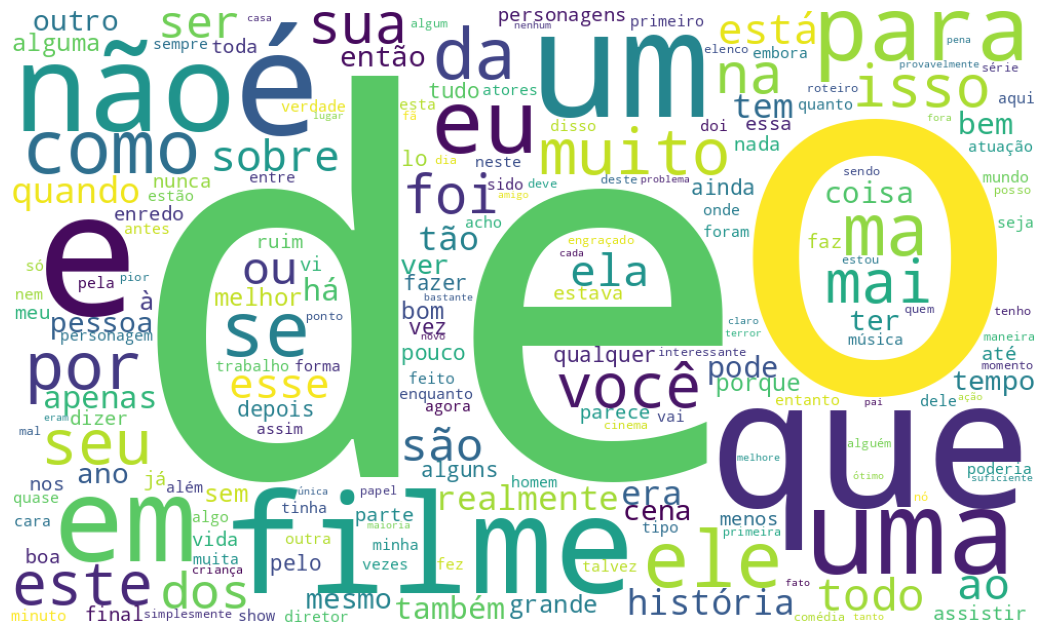

In [84]:
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [85]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [86]:
import pyspark.sql.functions as f

In [87]:
example = spark.createDataFrame([
                ("Oi, JP! Blz?",),
                ("$$$\\ |~ Parabéns ~| \\$$$",),
                ("(#amovc #paz&amor ^.^)",),
                ("\"bora *_* \"",),
                ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
                ("{comprar: arroz; feijão e pepino} //",),
                ("!\"#$&'()*+,-./:;<=>?@[\]^_`{|}~",),
                ("ana@gmail.com",)
        ], ["texts"])

In [88]:
example = example.withColumn('text_regex', f.regexp_replace("texts", "[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]", ""))
example.show(truncate=False)

+------------------------------------------+-------------------------------+
|texts                                     |text_regex                     |
+------------------------------------------+-------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                      |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                  |
|"bora *_* "                               |bora                           |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad             |
|{comprar: arroz; feijão e pepino} //      |comprar: arroz feijão e pepino |
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |:[]                            |
|ana@gmail.com                             |anagmailcom                    |
+------------------------------------------+-------------------------------+



In [89]:
example = example.withColumn('clean_data', f.trim(example.text_regex))

In [90]:
example.show(truncate=False)

+------------------------------------------+-------------------------------+------------------------------+
|texts                                     |text_regex                     |clean_data                    |
+------------------------------------------+-------------------------------+------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                      |Oi JP Blz                     |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                     |Parabéns                      |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                  |amovc pazamor                 |
|"bora *_* "                               |bora                           |bora                          |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad             |vc foi selecionad             |
|{comprar: arroz; feijão e pepino} //      |comprar: arroz feijão e pepino |comprar: arroz feijão e pepino|
|!"#$&'()*+,-./:;<=>?@[\]^_`

In [91]:
data = data.withColumn('text_regex', f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]", ""))

In [92]:
data = data.withColumn("clean_text", f.trim(data.text_regex))

In [93]:
data.limit(10).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|          text_regex|          clean_text|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|A funny thing hap...|A funny thing hap...|
|  7|This German horro...|Este filme de ter...|      neg|This German horro...|This German horro...|


# Tokenization

In [94]:
from pyspark.ml.feature import Tokenizer

In [95]:
tokenizer = Tokenizer(inputCol='clean_text', outputCol='tokens')

In [96]:
tokenized = tokenizer.transform(data)

In [97]:
tokenized.select('clean_text', 'tokens').show()

+--------------------+--------------------+
|          clean_text|              tokens|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|
|This German horro...|[this, german, ho...|
|Being a longtime ...|[being, a, longti...|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|
|Wealthy horse ran...|[wealthy, horse, ...|
|Cage plays a drun...|[cage, plays, a, ...|
|First of all I wo...|[first, of, all, ...|
|So tell me  what ...|[so, tell, me, , ...|
|A big disappointm...|[a, big, disappoi...|
|This film is abso...|[this, film, is, ...|
|Heres a decidedly...|[heres, a, decide...|
|At the bottom end...|[at, the, bottom,...|
|Earth has been de...|[earth, has, been...|
|Many people are s...|[many, people, ar...|
|New York family i...|[new, york

In [98]:
from pyspark.sql.types import IntegerType

In [99]:
countTokens = f.udf(lambda tokens: len(tokens), IntegerType())

In [100]:
tokenized.select('clean_text', 'tokens')\
  .withColumn('freq_tokens', countTokens(f.col('tokens')))\
  .show()

+--------------------+--------------------+-----------+
|          clean_text|              tokens|freq_tokens|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
|A funny thing hap...|[a, funny, thing,...|        115|
|This German horro...|[this, german, ho...|        156|
|Being a longtime ...|[being, a, longti...|        136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|        129|
|Wealthy horse ran...|[wealthy, horse, ...|        160|
|Cage plays a drun...|[cage, plays, a, ...|        109|
|First of all I wo...|[first, of, all, ...|        333|
|So tell me  what ...|[so, tell, me, , ...|        243|
|A big disappointm...|[a, big, disappoi...|        110|
|This film is abso...|[this, film, is, ...|     

# StopWords

In [101]:
from pyspark.ml.feature import StopWordsRemover

In [102]:
remover = StopWordsRemover(inputCol='tokens', outputCol='final_text')

In [103]:
feature_data = remover.transform(tokenized)

In [104]:
feature_data.limit(10).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|          text_regex|          clean_text|              tokens|          final_text|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|[example, majorit...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|[first, hate, mor...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|[not, even, the, ...|[even, beatles, w...|
|  5|B

In [105]:
feature_data.select('tokens', 'final_text')\
  .withColumn('freq_tokens', countTokens(f.col('tokens')))\
  .withColumn('freq_tokens_clean', countTokens(f.col('final_text'))).show()

+--------------------+--------------------+-----------+-----------------+
|              tokens|          final_text|freq_tokens|freq_tokens_clean|
+--------------------+--------------------+-----------+-----------------+
|[once, again, mr,...|[mr, costner, dra...|        168|               73|
|[this, is, an, ex...|[example, majorit...|        232|              131|
|[first, of, all, ...|[first, hate, mor...|        215|              111|
|[not, even, the, ...|[even, beatles, w...|        308|              169|
|[brass, pictures,...|[brass, pictures,...|        238|              140|
|[a, funny, thing,...|[funny, thing, ha...|        115|               52|
|[this, german, ho...|[german, horror, ...|        156|               74|
|[being, a, longti...|[longtime, fan, j...|        136|               73|
|[tokyo, eyes, tel...|[tokyo, eyes, tel...|        129|               75|
|[wealthy, horse, ...|[wealthy, horse, ...|        160|               99|
|[cage, plays, a, ...|[cage, plays, dr

# Bag of Words

In [106]:
from pyspark.ml.feature import CountVectorizer

In [107]:
cv = CountVectorizer(inputCol='final_text', outputCol='count_vec')

In [108]:
model = cv.fit(feature_data)

In [109]:
countVectorizer_features = model.transform(feature_data)

In [110]:
countVectorizer_features.select('final_text', 'count_vec').limit(10).show()

+--------------------+--------------------+
|          final_text|           count_vec|
+--------------------+--------------------+
|[mr, costner, dra...|(221187,[0,7,8,11...|
|[example, majorit...|(221187,[1,2,3,8,...|
|[first, hate, mor...|(221187,[0,2,4,11...|
|[even, beatles, w...|(221187,[0,1,2,4,...|
|[brass, pictures,...|(221187,[1,3,5,8,...|
|[funny, thing, ha...|(221187,[1,2,7,22...|
|[german, horror, ...|(221187,[0,1,2,7,...|
|[longtime, fan, j...|(221187,[0,1,5,8,...|
|[tokyo, eyes, tel...|(221187,[1,4,9,10...|
|[wealthy, horse, ...|(221187,[6,7,10,1...|
+--------------------+--------------------+



# Bag of Words with HashingTF

In [111]:
from pyspark.ml.feature import HashingTF

In [112]:
hashingTF = HashingTF(inputCol='final_text', outputCol='hashingTF').setNumFeatures(50)

In [113]:
HTFfeaturizedData = hashingTF.transform(countVectorizer_features)

In [114]:
HTFfeaturizedData.select('final_text', 'hashingTF').limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# TF-IDF

In [115]:
from pyspark.ml.feature import IDF

In [116]:
idf = IDF(inputCol='hashingTF', outputCol='features')

In [117]:
idfModel = idf.fit(HTFfeaturizedData)

In [118]:
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)

In [119]:
TFIDFfeaturizedData.select('final_text', 'features').limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Coding

In [120]:
TFIDFfeaturizedData.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [121]:
from pyspark.ml.feature import StringIndexer

In [122]:
stringindexer = StringIndexer(inputCol='sentiment', outputCol='label')

In [123]:
data = stringindexer.fit(data).transform(data)

In [124]:
data.groupBy(['sentiment', 'label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



# Pipeline

In [125]:
from pyspark.ml import Pipeline

In [126]:
tokenizer = Tokenizer(inputCol='clean_text', outputCol='tokens')
stopwords = StopWordsRemover(inputCol='tokens', outputCol='final_text')
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol='HTF', numFeatures=1000)
idf = IDF(inputCol='HTF', outputCol='features')

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, idf])

In [128]:
data_transformed = pipeline.fit(data).transform(data)

In [129]:
data_transformed.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|          text_regex|          clean_text|label|              tokens|          final_text|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|  0.0|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|
|  3|First of all I ha...|Primeiro de tudo ...|   

# Classification

*   Logistic Regression
*   Decision Tree
*   XGBoost

Decision Tree

In [130]:
featureDF = data_transformed.select(['features', 'label'])

In [131]:
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [132]:
from pyspark.ml.classification import DecisionTreeClassifier

In [133]:
tokenizer = Tokenizer(inputCol='clean_text', outputCol='tokens')
stopwords = StopWordsRemover(inputCol='tokens', outputCol='final_text')
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol='HTF', numFeatures=1000)
idf = IDF(inputCol='HTF', outputCol='features')
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10)

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, idf, dt])

sample train and test

In [134]:
train, test = data.randomSplit([0.7, 0.3], seed=101)

In [135]:
dt_model = pipeline.fit(train)

In [136]:
predictions = dt_model.transform(test)

In [137]:
predictions.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|          text_regex|          clean_text|label|              tokens|          final_text|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|  0.0|[brass, pictures,...|[brass, pictures,...|(1000,[3,6,7,11,3...|(1000,[3,6,7,11,3...| [369.0,1108.0]|[0.24983073798239...|       1.0|
|  6|A funny thing hap...|Uma coisa engraça...| 

Metrics

In [138]:
predictions.select(['label', 'prediction']).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [139]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [144]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

In [146]:
accuracy = evaluator.evaluate(predictions)

In [148]:
print("Accuracy = %s" % (accuracy))

Accuracy = 0.6724696356275304


Testing two new phrases

In [149]:
new_data = spark.createDataFrame(
    [(1, "This is one of the worst movies I've ever watched"), (2, "Excelent movie")],
    ["id", "clean_text"]
    )

In [150]:
new_data.show()

+---+--------------------+
| id|          clean_text|
+---+--------------------+
|  1|This is one of th...|
|  2|      Excelent movie|
+---+--------------------+



In [151]:
new_class = dt_model.transform(new_data)

In [152]:
new_class.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|          clean_text|              tokens|          final_text|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  1|This is one of th...|[this, is, one, o...|[one, worst, movi...|(1000,[37,332,594...|(1000,[37,332,594...|  [669.0,105.0]|[0.86434108527131...|       0.0|
|  2|      Excelent movie|   [excelent, movie]|   [excelent, movie]|(1000,[439,467],[...|(1000,[439,467],[...|[2431.0,3152.0]|[0.43542898083467...|       1.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+

